# top500航线数据处理  

固定出发日期，清洗数据提前0-59天搜索的价格走势

1. top500_airroute.gz top500航线价格2年
压缩命令：gzip bs_ctrip_20180514.csv    
2. 主要特征：dep_city arr_city search_date dep_date pre_day  minprice  
3. 按航线填充，保证没有价格=0，或者不符合常理的数据

# 导入包

In [5]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, date, timedelta
import time
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
import random

# 读取数据

In [2]:
inputfile='../datasets/top500_airroute.gz'
outfile='../datasets/top500_airroute_preprocessed.csv' # 将处理后的数据输出

In [3]:
%time data=pd.read_csv(inputfile,compression='gzip',sep='\t',parse_dates=['search_date','dep_date'])

CPU times: user 1min 39s, sys: 2.24 s, total: 1min 42s
Wall time: 1min 41s


In [4]:
df = data.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40522039 entries, 0 to 40522038
Data columns (total 5 columns):
dep_city       object
arr_city       object
dep_date       datetime64[ns]
search_date    datetime64[ns]
minprice       float64
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 1.5+ GB


# 数据处理

## 1. 增加route字段，labelEnconder增加label字段(0-499)

In [6]:
# 增加route字段
df['route'] = np.nan
df['route'] = df['dep_city']+'-'+df['arr_city']

In [7]:
# 增加label字段
%time label = LabelEncoder().fit_transform(df.route)
df.insert(df.shape[1],'label',label)
df.sort_values(by=['label'],inplace=True)
df.reset_index(inplace=True)
df.drop('index',inplace=True,axis=1)

CPU times: user 1min 17s, sys: 3.58 s, total: 1min 21s
Wall time: 1min 20s


In [8]:
df.head()

,dep_city,arr_city,dep_date,search_date,minprice,route,label
0,三亚,上海,2016-12-10,2016-11-11,182.0,三亚-上海,0
1,三亚,上海,2018-02-20,2017-11-08,1947.0,三亚-上海,0
2,三亚,上海,2018-02-10,2017-11-09,1190.0,三亚-上海,0
3,三亚,上海,2017-12-09,2017-11-10,100.0,三亚-上海,0
4,三亚,上海,2018-02-28,2017-11-19,1910.0,三亚-上海,0


In [9]:
df.tail()

,dep_city,arr_city,dep_date,search_date,minprice,route,label
40522034,青岛,长沙,2016-07-03,2016-05-03,660.0,青岛-长沙,499
40522035,青岛,长沙,2016-05-30,2016-05-14,313.0,青岛-长沙,499
40522036,青岛,长沙,2016-05-20,2016-05-15,334.0,青岛-长沙,499
40522037,青岛,长沙,2016-03-20,2016-03-19,505.0,青岛-长沙,499
40522038,青岛,长沙,2017-11-23,2017-11-14,391.0,青岛-长沙,499


## 2. 500条航线分为10份，分批添加提前天数

In [10]:
# 50条航线为一份，数据分为10份
n = 10
total = [None]*n
blocksize = int(500/n)
for i in range(n):
    total[i] = df[(df.label>=i*blocksize)&(df.label<(i+1)*blocksize)]
    print(total[i].shape)

(4602539, 7)
(4125344, 7)
(3757524, 7)
(4137159, 7)
(4378302, 7)
(4071778, 7)
(4018987, 7)
(3766279, 7)
(3642996, 7)
(4021131, 7)


In [11]:
# 添加提前天数字段
for df in total:
    df['pre_day'] = np.nan
    df['pre_day'] = df['dep_date']-df['search_date']
    df.pre_day = df.pre_day.apply(lambda x:x.days)

## 3. 抽样航线查看价格波动

In [27]:
df_random = total[random.randint(0,9)]

In [32]:
label_random = list(set(df_random.label.values))

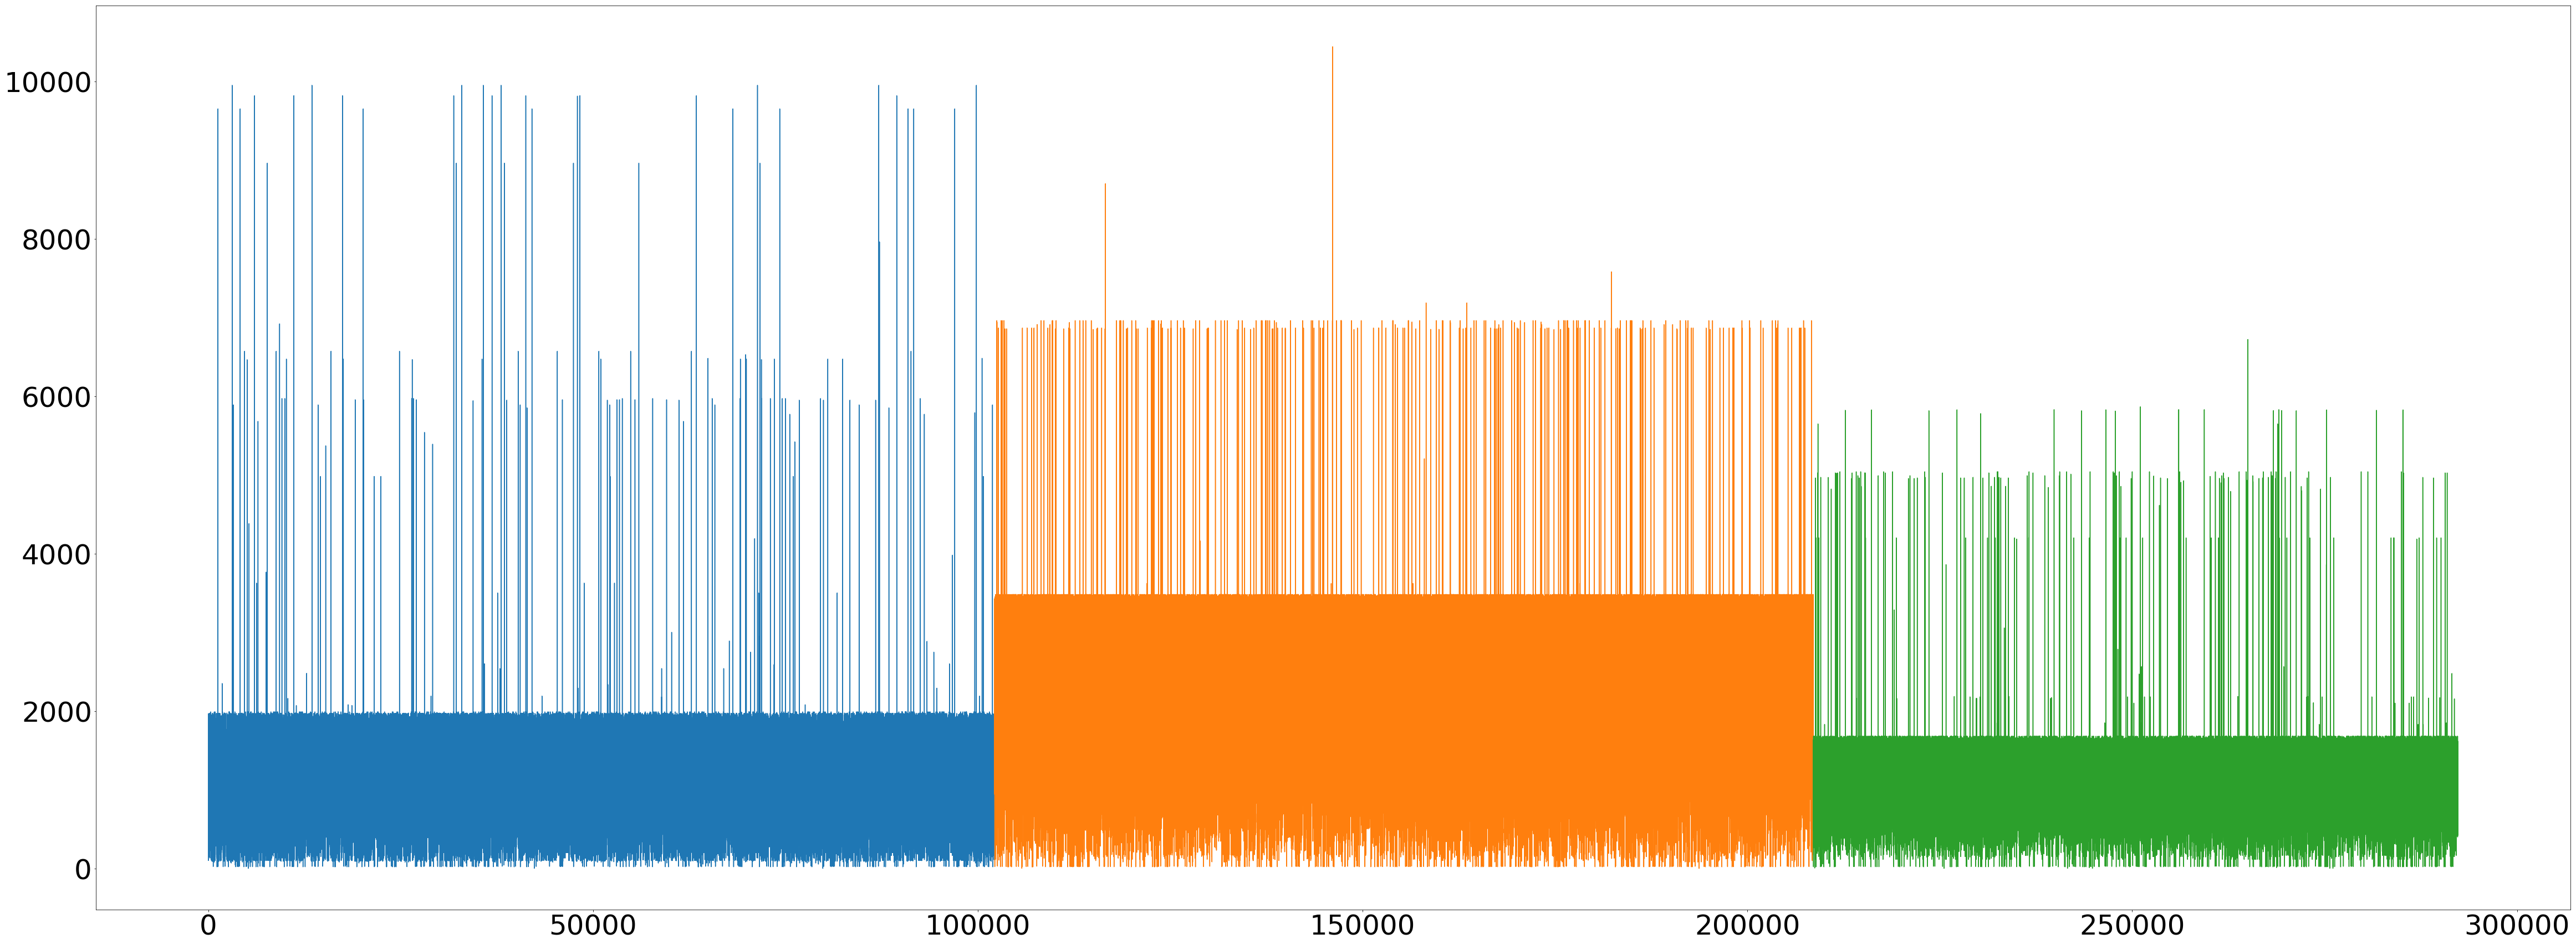

In [50]:
fig = plt.figure(figsize=(80,30))
ax = fig.add_subplot(111)
xaxis = ax.yaxis        
for line in xaxis.get_ticklabels():
    line.set_fontsize(50)          # 设置字体大小;
yaxis = ax.xaxis        
for line in yaxis.get_ticklabels():
    line.set_fontsize(50)          # 设置字体大小;
for i in range(0,3):
    df_random.loc[(df_random.label==label_random[i]),'minprice'].plot()

In [58]:
df_random.loc[df_random.label<3,'route'].value_counts()

三亚-哈尔滨    106413
三亚-上海     102144
三亚-成都      83772
Name: route, dtype: int64

In [62]:
len(df_random.loc[(df_random.minprice>8000)&(df_random.label==0),['dep_date','search_date']])

33

In [68]:
df_random.loc[(df_random.dep_date=='2018-03-30')&(df_random.search_date=='2018-02-07')&(df_random.label==1),['dep_date','search_date','route','minprice']]

,dep_date,search_date,route,minprice
130812,2018-03-30,2018-02-07,三亚-哈尔滨,1940.0


## 4. 异常值处理
1. 去除提前天数超过2个月的数据  
2. 0.25以下0.75以上的基本为异常值，价格又跟提前天数等有关系，所以必须用相邻的均值补充
3. 按照航线去处理异常值
4. 异常值在构建完整的数据后再处理

In [172]:
for i in range(len(total)):
    total[i] = total[i][total[i].pre_day<60]
for df in total:
    print(df.shape)

(2478343, 8)
(2398856, 8)
(2389271, 8)
(2456537, 8)
(2458206, 8)
(2432749, 8)
(2443377, 8)
(2382245, 8)
(2365247, 8)
(2444824, 8)


In [173]:
total_copy = total.copy()

In [14]:
# 查看各航线价格数据分位数
for df in total_copy:
    label_list = list(set(df.label.values))
    for route_num in label_list:
        rows = df.loc[(df.label == route_num),'minprice'].shape[0]
        min05= df.loc[df.label == route_num,'minprice'].quantile(0.05)
        min10= df.loc[df.label == route_num,'minprice'].quantile(0.1)
        max90 = df.loc[df.label == route_num,'minprice'].quantile(0.9)
        max95 = df.loc[df.label == route_num,'minprice'].quantile(0.95)
        min05_rate = df.loc[(df.label == route_num)&(df.minprice<=min05),'minprice'].shape[0]/rows
        min10_rate = df.loc[(df.label == route_num)&(df.minprice<=min10),'minprice'].shape[0]/rows
        max90_rate = df.loc[(df.label == route_num)&(df.minprice>=max90),'minprice'].shape[0]/rows
        max95_rate = df.loc[(df.label == route_num)&(df.minprice>=max95),'minprice'].shape[0]/rows
        print('---航线%s---0.05分位数：%s，占比：%.2f'%(route_num,min05,min05_rate))
        print('---航线%s---0.1 分位数：%s，占比：%.2f'%(route_num,min10,min10_rate))
        print('---航线%s---0.9 分位数：%s，占比：%.2f'%(route_num,max90,max90_rate))
        print('---航线%s---0.95分位数：%s，占比：%.2f'%(route_num,max95,max95_rate))
#         df.loc[(df.label == route_num)&(df.minprice<=minimum),'minprice'] = minimum
#         df.loc[(df.label == route_num)&(df.minprice>=maximum),'minprice'] = maximum

---航线0---0.05分位数：270.0，占比：0.05
---航线0---0.1 分位数：390.0，占比：0.11
---航线0---0.9 分位数：1475.0，占比：0.10
---航线0---0.95分位数：1880.0，占比：0.05
---航线1---0.05分位数：505.0，占比：0.05
---航线1---0.1 分位数：700.0，占比：0.11
---航线1---0.9 分位数：3441.0，占比：0.10
---航线1---0.95分位数：3461.0，占比：0.05
---航线2---0.05分位数：425.0，占比：0.05
---航线2---0.1 分位数：483.0，占比：0.10
---航线2---0.9 分位数：1627.0，占比：0.11
---航线2---0.95分位数：1650.0，占比：0.05
---航线3---0.05分位数：320.0，占比：0.06
---航线3---0.1 分位数：374.0，占比：0.10
---航线3---0.9 分位数：1168.0，占比：0.10
---航线3---0.95分位数：1375.0，占比：0.05
---航线4---0.05分位数：285.0，占比：0.05
---航线4---0.1 分位数：375.0，占比：0.12
---航线4---0.9 分位数：1636.0，占比：0.10
---航线4---0.95分位数：1875.0，占比：0.05
---航线5---0.05分位数：280.0，占比：0.06
---航线5---0.1 分位数：329.0，占比：0.10
---航线5---0.9 分位数：915.0，占比：0.10
---航线5---0.95分位数：930.0，占比：0.06
---航线6---0.05分位数：295.0，占比：0.06
---航线6---0.1 分位数：360.0，占比：0.10
---航线6---0.9 分位数：1720.0，占比：0.10
---航线6---0.95分位数：1936.0，占比：0.05
---航线7---0.05分位数：334.0，占比：0.05
---航线7---0.1 分位数：405.0，占比：0.10
---航线7---0.9 分位数：1851.0，占比：0.10
---航线7---0.95分位数：2030.0，占比

---航线65---0.05分位数：94.0，占比：0.09
---航线65---0.1 分位数：112.0，占比：0.10
---航线65---0.9 分位数：588.0，占比：0.10
---航线65---0.95分位数：680.0，占比：0.05
---航线66---0.05分位数：330.0，占比：0.07
---航线66---0.1 分位数：346.0，占比：0.10
---航线66---0.9 分位数：660.0，占比：0.12
---航线66---0.95分位数：770.0，占比：0.05
---航线67---0.05分位数：240.0，占比：0.05
---航线67---0.1 分位数：294.0，占比：0.10
---航线67---0.9 分位数：948.0，占比：0.10
---航线67---0.95分位数：995.0，占比：0.05
---航线68---0.05分位数：496.0，占比：0.05
---航线68---0.1 分位数：599.0，占比：0.10
---航线68---0.9 分位数：1980.0，占比：0.10
---航线68---0.95分位数：2600.0，占比：0.05
---航线69---0.05分位数：239.0，占比：0.05
---航线69---0.1 分位数：265.0，占比：0.10
---航线69---0.9 分位数：1117.0，占比：0.10
---航线69---0.95分位数：1290.0，占比：0.05
---航线70---0.05分位数：82.0，占比：0.05
---航线70---0.1 分位数：109.0，占比：0.10
---航线70---0.9 分位数：620.0，占比：0.10
---航线70---0.95分位数：680.0，占比：0.06
---航线71---0.05分位数：600.0，占比：0.06
---航线71---0.1 分位数：635.0，占比：0.10
---航线71---0.9 分位数：1955.0，占比：0.10
---航线71---0.95分位数：2130.0，占比：0.05
---航线72---0.05分位数：260.0，占比：0.05
---航线72---0.1 分位数：290.0，占比：0.17
---航线72---0.9 分位数：1030.0，占比：0.10
---

---航线108---0.05分位数：320.0，占比：0.05
---航线108---0.1 分位数：350.0，占比：0.11
---航线108---0.9 分位数：1220.0，占比：0.10
---航线108---0.95分位数：1390.0，占比：0.05
---航线109---0.05分位数：339.0，占比：0.05
---航线109---0.1 分位数：400.0，占比：0.10
---航线109---0.9 分位数：1627.0，占比：0.10
---航线109---0.95分位数：1685.0，占比：0.05
---航线110---0.05分位数：630.0，占比：0.05
---航线110---0.1 分位数：683.0，占比：0.10
---航线110---0.9 分位数：2079.0，占比：0.10
---航线110---0.95分位数：2130.0，占比：0.07
---航线111---0.05分位数：299.0，占比：0.05
---航线111---0.1 分位数：369.0，占比：0.10
---航线111---0.9 分位数：1169.0，占比：0.10
---航线111---0.95分位数：1480.0，占比：0.05
---航线112---0.05分位数：383.0，占比：0.05
---航线112---0.1 分位数：436.0，占比：0.10
---航线112---0.9 分位数：1035.0，占比：0.10
---航线112---0.95分位数：1056.0，占比：0.05
---航线113---0.05分位数：257.0，占比：0.05
---航线113---0.1 分位数：267.0，占比：0.10
---航线113---0.9 分位数：712.0，占比：0.10
---航线113---0.95分位数：879.0，占比：0.05
---航线114---0.05分位数：330.0，占比：0.06
---航线114---0.1 分位数：368.90000000000055，占比：0.10
---航线114---0.9 分位数：1188.0，占比：0.10
---航线114---0.95分位数：1755.0，占比：0.05
---航线115---0.05分位数：60.0，占比：0.05
---航线115---0.1 分位数：

---航线192---0.05分位数：431.0，占比：0.05
---航线192---0.1 分位数：479.0，占比：0.13
---航线192---0.9 分位数：1511.0，占比：0.10
---航线192---0.95分位数：1823.0，占比：0.05
---航线193---0.05分位数：390.0，占比：0.05
---航线193---0.1 分位数：450.0，占比：0.10
---航线193---0.9 分位数：1190.0，占比：0.10
---航线193---0.95分位数：1545.0，占比：0.05
---航线194---0.05分位数：310.0，占比：0.05
---航线194---0.1 分位数：340.0，占比：0.11
---航线194---0.9 分位数：890.0，占比：0.10
---航线194---0.95分位数：1049.0，占比：0.05
---航线195---0.05分位数：413.0，占比：0.05
---航线195---0.1 分位数：500.0，占比：0.10
---航线195---0.9 分位数：1337.0，占比：0.10
---航线195---0.95分位数：1399.0，占比：0.05
---航线196---0.05分位数：310.0，占比：0.06
---航线196---0.1 分位数：329.0，占比：0.10
---航线196---0.9 分位数：969.0，占比：0.10
---航线196---0.95分位数：1279.449999999997，占比：0.05
---航线197---0.05分位数：308.0，占比：0.05
---航线197---0.1 分位数：320.0，占比：0.13
---航线197---0.9 分位数：1050.0，占比：0.10
---航线197---0.95分位数：1150.0，占比：0.06
---航线198---0.05分位数：340.0，占比：0.05
---航线198---0.1 分位数：399.0，占比：0.10
---航线198---0.9 分位数：840.0，占比：0.10
---航线198---0.95分位数：1050.0，占比：0.05
---航线199---0.05分位数：540.0，占比：0.05
---航线199---0.1 分位数：59

---航线259---0.05分位数：216.0，占比：0.05
---航线259---0.1 分位数：276.0，占比：0.10
---航线259---0.9 分位数：558.0，占比：0.10
---航线259---0.95分位数：710.0，占比：0.05
---航线260---0.05分位数：180.0，占比：0.05
---航线260---0.1 分位数：215.0，占比：0.10
---航线260---0.9 分位数：665.9000000000087，占比：0.10
---航线260---0.95分位数：799.0，占比：0.05
---航线261---0.05分位数：170.0，占比：0.06
---航线261---0.1 分位数：210.0，占比：0.11
---航线261---0.9 分位数：882.0，占比：0.10
---航线261---0.95分位数：1150.0，占比：0.05
---航线262---0.05分位数：265.0，占比：0.06
---航线262---0.1 分位数：300.0，占比：0.11
---航线262---0.9 分位数：920.0，占比：0.10
---航线262---0.95分位数：1180.0，占比：0.05
---航线263---0.05分位数：163.0，占比：0.05
---航线263---0.1 分位数：185.0，占比：0.10
---航线263---0.9 分位数：555.0，占比：0.10
---航线263---0.95分位数：730.0，占比：0.05
---航线264---0.05分位数：205.0，占比：0.05
---航线264---0.1 分位数：250.0，占比：0.10
---航线264---0.9 分位数：840.0，占比：0.10
---航线264---0.95分位数：1050.0，占比：0.05
---航线265---0.05分位数：313.0，占比：0.05
---航线265---0.1 分位数：347.0，占比：0.10
---航线265---0.9 分位数：1469.0，占比：0.10
---航线265---0.95分位数：1740.0，占比：0.06
---航线266---0.05分位数：336.0，占比：0.05
---航线266---0.1 分位数：370.0，占

---航线315---0.05分位数：369.0，占比：0.05
---航线315---0.1 分位数：470.0，占比：0.10
---航线315---0.9 分位数：2191.9000000000087，占比：0.10
---航线315---0.95分位数：2347.0，占比：0.05
---航线316---0.05分位数：195.0，占比：0.05
---航线316---0.1 分位数：295.0，占比：0.11
---航线316---0.9 分位数：1889.0，占比：0.10
---航线316---0.95分位数：1940.0，占比：0.06
---航线317---0.05分位数：85.0，占比：0.05
---航线317---0.1 分位数：110.0，占比：0.11
---航线317---0.9 分位数：666.0，占比：0.10
---航线317---0.95分位数：948.0，占比：0.05
---航线318---0.05分位数：149.0，占比：0.05
---航线318---0.1 分位数：245.0，占比：0.11
---航线318---0.9 分位数：1190.0，占比：0.10
---航线318---0.95分位数：1235.0，占比：0.05
---航线319---0.05分位数：379.0，占比：0.05
---航线319---0.1 分位数：625.0，占比：0.10
---航线319---0.9 分位数：3170.0，占比：0.10
---航线319---0.95分位数：3291.0，占比：0.05
---航线320---0.05分位数：179.0，占比：0.06
---航线320---0.1 分位数：199.0，占比：0.11
---航线320---0.9 分位数：1089.4000000000087，占比：0.10
---航线320---0.95分位数：1280.0，占比：0.06
---航线321---0.05分位数：319.0，占比：0.05
---航线321---0.1 分位数：443.0，占比：0.10
---航线321---0.9 分位数：1687.0，占比：0.11
---航线321---0.95分位数：1710.0，占比：0.06
---航线322---0.05分位数：200.0，占比：0.05
---航线322

---航线361---0.05分位数：250.0，占比：0.05
---航线361---0.1 分位数：284.0，占比：0.10
---航线361---0.9 分位数：936.0，占比：0.10
---航线361---0.95分位数：1080.0，占比：0.05
---航线362---0.05分位数：265.0，占比：0.06
---航线362---0.1 分位数：300.0，占比：0.12
---航线362---0.9 分位数：890.8000000000029，占比：0.10
---航线362---0.95分位数：1145.0，占比：0.05
---航线363---0.05分位数：230.0，占比：0.05
---航线363---0.1 分位数：264.0，占比：0.10
---航线363---0.9 分位数：1101.0，占比：0.10
---航线363---0.95分位数：1220.0，占比：0.05
---航线364---0.05分位数：308.0，占比：0.05
---航线364---0.1 分位数：344.0，占比：0.10
---航线364---0.9 分位数：1660.0，占比：0.10
---航线364---0.95分位数：1745.0，占比：0.05
---航线365---0.05分位数：295.0，占比：0.05
---航线365---0.1 分位数：330.0，占比：0.11
---航线365---0.9 分位数：1155.0，占比：0.10
---航线365---0.95分位数：1458.0，占比：0.05
---航线366---0.05分位数：213.0，占比：0.05
---航线366---0.1 分位数：293.0，占比：0.10
---航线366---0.9 分位数：1166.0，占比：0.10
---航线366---0.95分位数：1235.0，占比：0.05
---航线367---0.05分位数：189.0，占比：0.06
---航线367---0.1 分位数：215.0，占比：0.10
---航线367---0.9 分位数：650.0，占比：0.10
---航线367---0.95分位数：1000.0，占比：0.05
---航线368---0.05分位数：370.0，占比：0.06
---航线368---0.1 分位数：4

---航线439---0.05分位数：324.0，占比：0.05
---航线439---0.1 分位数：349.0，占比：0.10
---航线439---0.9 分位数：940.0，占比：0.10
---航线439---0.95分位数：1383.0，占比：0.05
---航线440---0.05分位数：228.0，占比：0.05
---航线440---0.1 分位数：257.0，占比：0.10
---航线440---0.9 分位数：833.0，占比：0.10
---航线440---0.95分位数：1037.0，占比：0.05
---航线441---0.05分位数：227.0，占比：0.05
---航线441---0.1 分位数：245.0，占比：0.10
---航线441---0.9 分位数：977.8000000000029，占比：0.10
---航线441---0.95分位数：1149.0，占比：0.05
---航线442---0.05分位数：190.0，占比：0.06
---航线442---0.1 分位数：224.0，占比：0.10
---航线442---0.9 分位数：778.0，占比：0.10
---航线442---0.95分位数：1279.0，占比：0.05
---航线443---0.05分位数：241.0，占比：0.05
---航线443---0.1 分位数：275.0，占比：0.10
---航线443---0.9 分位数：868.0，占比：0.10
---航线443---0.95分位数：1025.0，占比：0.05
---航线444---0.05分位数：182.0，占比：0.05
---航线444---0.1 分位数：196.0，占比：0.12
---航线444---0.9 分位数：610.0，占比：0.10
---航线444---0.95分位数：745.0，占比：0.05
---航线445---0.05分位数：310.0，占比：0.06
---航线445---0.1 分位数：340.0，占比：0.11
---航线445---0.9 分位数：1496.0，占比：0.10
---航线445---0.95分位数：1520.0，占比：0.06
---航线446---0.05分位数：290.0，占比：0.06
---航线446---0.1 分位数：340.0

In [174]:
# 0.1以下0.99以上认为是异常值,填充为对应的分位数
for df in total_copy:
    label_list = list(set(df.label.values))
    for route_num in label_list:   
        min10= df.loc[df.label == route_num,'minprice'].quantile(0.1)
        max99 = df.loc[df.label == route_num,'minprice'].quantile(0.99)
        print('---航线%s---  0.1 分位数：%s，0.99分位数：%s'%(route_num,min10,max99))
        df.loc[(df.label == route_num)&(df.minprice<=min10),'minprice'] = min10
        df.loc[(df.label == route_num)&(df.minprice>=max99),'minprice'] = max99

---航线0---  0.1 分位数：390.0，0.99分位数：1935.0


/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


---航线1---  0.1 分位数：700.0，0.99分位数：3095.0
---航线2---  0.1 分位数：483.0，0.99分位数：1639.0
---航线3---  0.1 分位数：374.0，0.99分位数：1410.0
---航线4---  0.1 分位数：375.0，0.99分位数：1900.0
---航线5---  0.1 分位数：330.0，0.99分位数：1400.0
---航线6---  0.1 分位数：360.0，0.99分位数：1936.0
---航线7---  0.1 分位数：405.0，0.99分位数：2020.0
---航线8---  0.1 分位数：294.0，0.99分位数：1480.0
---航线9---  0.1 分位数：290.0，0.99分位数：1410.0
---航线10---  0.1 分位数：740.0，0.99分位数：2320.0
---航线11---  0.1 分位数：310.0，0.99分位数：1500.0
---航线12---  0.1 分位数：345.0，0.99分位数：718.0
---航线13---  0.1 分位数：329.0，0.99分位数：1330.0
---航线14---  0.1 分位数：259.0，0.99分位数：755.0
---航线15---  0.1 分位数：355.0，0.99分位数：1700.0
---航线16---  0.1 分位数：190.0，0.99分位数：938.1406079999974
---航线17---  0.1 分位数：200.0，0.99分位数：670.0
---航线18---  0.1 分位数：264.0，0.99分位数：1120.0
---航线19---  0.1 分位数：429.0，0.99分位数：950.0
---航线20---  0.1 分位数：447.0，0.99分位数：1430.0
---航线21---  0.1 分位数：429.0，0.99分位数：1500.0
---航线22---  0.1 分位数：280.0，0.99分位数：1200.0
---航线23---  0.1 分位数：170.0，0.99分位数：711.0
---航线24---  0.1 分位数：345.0，0.99分位数：1730.0
---航线25---  0.1 分位数

---航线199---  0.1 分位数：596.0，0.99分位数：1464.25
---航线200---  0.1 分位数：210.0，0.99分位数：1260.0
---航线201---  0.1 分位数：277.0，0.99分位数：960.0
---航线202---  0.1 分位数：380.0，0.99分位数：1369.0
---航线203---  0.1 分位数：320.0，0.99分位数：1190.0
---航线204---  0.1 分位数：660.0，0.99分位数：1483.0
---航线205---  0.1 分位数：625.0，0.99分位数：2480.0
---航线206---  0.1 分位数：449.0，0.99分位数：1813.0
---航线207---  0.1 分位数：459.0，0.99分位数：1621.0
---航线208---  0.1 分位数：507.0，0.99分位数：1537.0
---航线209---  0.1 分位数：511.0，0.99分位数：1940.0
---航线210---  0.1 分位数：230.0，0.99分位数：947.8199999999997
---航线211---  0.1 分位数：570.0，0.99分位数：1384.0
---航线212---  0.1 分位数：490.0，0.99分位数：1389.0
---航线213---  0.1 分位数：400.0，0.99分位数：1024.0
---航线214---  0.1 分位数：522.0，0.99分位数：1400.0
---航线215---  0.1 分位数：700.0，0.99分位数：1826.0999999999913
---航线216---  0.1 分位数：420.0，0.99分位数：1426.0
---航线217---  0.1 分位数：499.0，0.99分位数：1358.0
---航线218---  0.1 分位数：520.0，0.99分位数：1590.0
---航线219---  0.1 分位数：270.0，0.99分位数：739.0
---航线220---  0.1 分位数：460.0，0.99分位数：1434.0
---航线221---  0.1 分位数：452.0，0.99分位数：1050.0
---航线222--- 

---航线373---  0.1 分位数：373.0，0.99分位数：1223.0
---航线374---  0.1 分位数：279.0，0.99分位数：1057.0
---航线375---  0.1 分位数：469.0，0.99分位数：1433.0
---航线376---  0.1 分位数：138.0，0.99分位数：735.0
---航线377---  0.1 分位数：293.0，0.99分位数：1138.650000000016
---航线378---  0.1 分位数：253.0，0.99分位数：695.0
---航线379---  0.1 分位数：242.0，0.99分位数：950.0
---航线380---  0.1 分位数：381.0，0.99分位数：1762.5600000000632
---航线381---  0.1 分位数：373.0，0.99分位数：1290.0
---航线382---  0.1 分位数：105.0，0.99分位数：635.0
---航线383---  0.1 分位数：239.0，0.99分位数：1137.0
---航线400---  0.1 分位数：255.0，0.99分位数：1050.0
---航线401---  0.1 分位数：250.0，0.99分位数：956.5
---航线402---  0.1 分位数：115.0，0.99分位数：460.0
---航线403---  0.1 分位数：182.0，0.99分位数：710.0
---航线404---  0.1 分位数：324.0，0.99分位数：1710.0
---航线405---  0.1 分位数：360.0，0.99分位数：1454.0
---航线406---  0.1 分位数：350.0，0.99分位数：1720.0
---航线407---  0.1 分位数：292.0，0.99分位数：1030.0
---航线408---  0.1 分位数：122.0，0.99分位数：680.0
---航线409---  0.1 分位数：159.0，0.99分位数：926.0
---航线410---  0.1 分位数：199.0，0.99分位数：800.0
---航线411---  0.1 分位数：140.0，0.99分位数：630.0
---航线412---  0.1 分位数：1

In [66]:
# 查看异常值是否填充成功
for df in total_copy:
    label_list = list(set(df.label.values))
    for route_num in label_list:   
        minimum = df.loc[df.label == route_num,'minprice'].quantile(0)
        maximum = df.loc[df.label == route_num,'minprice'].quantile(1)
        print('---航线%s---  0.1 分位数：%s，0.99分位数：%s'%(route_num,minimum,maximum))

---航线0---  0.1 分位数：390.0，0.99分位数：1935.0
---航线1---  0.1 分位数：700.0，0.99分位数：3095.0
---航线2---  0.1 分位数：483.0，0.99分位数：1639.0
---航线3---  0.1 分位数：374.0，0.99分位数：1410.0
---航线4---  0.1 分位数：375.0，0.99分位数：1900.0
---航线5---  0.1 分位数：330.0，0.99分位数：1400.0
---航线6---  0.1 分位数：360.0，0.99分位数：1936.0
---航线7---  0.1 分位数：405.0，0.99分位数：2020.0
---航线8---  0.1 分位数：294.0，0.99分位数：1480.0
---航线9---  0.1 分位数：290.0，0.99分位数：1410.0
---航线10---  0.1 分位数：740.0，0.99分位数：2320.0
---航线11---  0.1 分位数：310.0，0.99分位数：1500.0
---航线12---  0.1 分位数：345.0，0.99分位数：719.3600000000006
---航线13---  0.1 分位数：329.0，0.99分位数：1330.0
---航线14---  0.1 分位数：259.0，0.99分位数：755.0
---航线15---  0.1 分位数：355.0，0.99分位数：1700.0
---航线16---  0.1 分位数：190.0，0.99分位数：938.5199999999968
---航线17---  0.1 分位数：200.0，0.99分位数：670.0
---航线18---  0.1 分位数：264.0，0.99分位数：1120.0
---航线19---  0.1 分位数：429.0，0.99分位数：950.0
---航线20---  0.1 分位数：447.0，0.99分位数：1430.0
---航线21---  0.1 分位数：429.0，0.99分位数：1500.0399999999936
---航线22---  0.1 分位数：280.0，0.99分位数：1200.0
---航线23---  0.1 分位数：170.0，0.99分位数：71

---航线199---  0.1 分位数：596.0，0.99分位数：1465.0
---航线200---  0.1 分位数：210.0，0.99分位数：1260.0
---航线201---  0.1 分位数：277.0，0.99分位数：962.5500000000029
---航线202---  0.1 分位数：380.0，0.99分位数：1369.0
---航线203---  0.1 分位数：320.0，0.99分位数：1190.0
---航线204---  0.1 分位数：660.0，0.99分位数：1484.0
---航线205---  0.1 分位数：625.0，0.99分位数：2482.0
---航线206---  0.1 分位数：449.0，0.99分位数：1814.0
---航线207---  0.1 分位数：459.0，0.99分位数：1621.0
---航线208---  0.1 分位数：507.0，0.99分位数：1541.0
---航线209---  0.1 分位数：511.0，0.99分位数：1940.0
---航线210---  0.1 分位数：230.0，0.99分位数：950.0
---航线211---  0.1 分位数：570.0，0.99分位数：1384.0
---航线212---  0.1 分位数：490.0，0.99分位数：1389.0
---航线213---  0.1 分位数：400.0，0.99分位数：1029.0
---航线214---  0.1 分位数：522.0，0.99分位数：1401.0
---航线215---  0.1 分位数：700.0，0.99分位数：1833.0
---航线216---  0.1 分位数：420.0，0.99分位数：1427.0
---航线217---  0.1 分位数：499.0，0.99分位数：1360.0
---航线218---  0.1 分位数：520.0，0.99分位数：1590.0
---航线219---  0.1 分位数：270.0，0.99分位数：740.0
---航线220---  0.1 分位数：460.0，0.99分位数：1434.0
---航线221---  0.1 分位数：452.0，0.99分位数：1055.0
---航线222---  0.1 分位数：537.

---航线383---  0.1 分位数：239.0，0.99分位数：1138.0
---航线400---  0.1 分位数：255.0，0.99分位数：1050.0
---航线401---  0.1 分位数：250.0，0.99分位数：980.0
---航线402---  0.1 分位数：115.0，0.99分位数：460.0
---航线403---  0.1 分位数：182.0，0.99分位数：711.0
---航线404---  0.1 分位数：324.0，0.99分位数：1717.0
---航线405---  0.1 分位数：360.0，0.99分位数：1454.0
---航线406---  0.1 分位数：350.0，0.99分位数：1729.550000000003
---航线407---  0.1 分位数：292.0，0.99分位数：1032.0
---航线408---  0.1 分位数：122.0，0.99分位数：680.0
---航线409---  0.1 分位数：159.0，0.99分位数：926.0
---航线410---  0.1 分位数：199.0，0.99分位数：805.0
---航线411---  0.1 分位数：140.0，0.99分位数：630.0
---航线412---  0.1 分位数：194.0，0.99分位数：750.0
---航线413---  0.1 分位数：215.0，0.99分位数：884.0
---航线414---  0.1 分位数：270.0，0.99分位数：1200.0
---航线415---  0.1 分位数：430.0，0.99分位数：1945.0
---航线416---  0.1 分位数：279.0，0.99分位数：1179.0
---航线417---  0.1 分位数：219.30000000000018，0.99分位数：916.0
---航线418---  0.1 分位数：291.0，0.99分位数：1071.0
---航线419---  0.1 分位数：280.0，0.99分位数：1198.0800000000017
---航线420---  0.1 分位数：145.0，0.99分位数：955.0
---航线421---  0.1 分位数：381.0，0.99分位数：1220.0
---航线422-

## 5. 缺失值处理  
出发日期：2016-1-1至2018-7-7  
以出发日期为准，构造提前0-60天的搜索日期


### 5.1 构建空结构

In [175]:
cols = ['dep_date','search_date','pre_day']
ts_range=pd.date_range('2016-1-1','2018-7-7')
blank=pd.DataFrame(columns=cols)
for dt in ts_range:
    p=pd.DataFrame(columns=cols)
    ts1=pd.date_range(dt,periods = 60,freq='1min') # 生成60个相同日期的数据dep_date
    ts2=pd.date_range(dt-timedelta(59),periods = 60,freq='D')    #search_date
    ts1=pd.to_datetime(ts1.date) # 将时分秒去掉 2018-07-07 00:55:00
    p.dep_date=ts1
    p.search_date=ts2    
    p.pre_day=(ts1-ts2).days
    blank=blank.append(p)

In [176]:
blank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55140 entries, 0 to 59
Data columns (total 3 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dtypes: datetime64[ns](2), object(1)
memory usage: 1.7+ MB


In [171]:
blank.dep_date.value_counts()

2017-03-24    60
2017-09-16    60
2018-04-24    60
2018-04-19    60
2016-01-06    60
2017-09-29    60
2016-08-08    60
2018-05-02    60
2016-01-19    60
2017-11-19    60
2017-02-26    60
2017-10-01    60
2016-08-21    60
2017-10-22    60
2018-01-02    60
2016-02-01    60
2018-04-23    60
2017-05-09    60
2016-09-03    60
2017-04-06    60
2016-02-14    60
2017-11-07    60
2016-09-16    60
2018-03-06    60
2018-01-25    60
2018-06-10    60
2016-02-27    60
2016-07-26    60
2017-12-18    60
2017-04-16    60
              ..
2017-11-22    60
2017-03-01    60
2016-07-15    60
2017-09-05    60
2016-06-06    60
2016-04-28    60
2018-01-20    60
2016-11-29    60
2016-05-11    60
2016-12-12    60
2016-05-24    60
2017-05-21    60
2017-12-01    60
2018-04-10    60
2016-12-25    60
2017-07-28    60
2018-01-29    60
2018-06-06    60
2018-02-28    60
2017-01-07    60
2018-02-08    60
2016-06-19    60
2018-01-12    60
2018-06-05    60
2017-01-20    60
2016-07-02    60
2017-09-07    60
2017-03-12    

### 5.2按照空结构blank将原始数据集dataset进行合并
2.  
出发日期范围： 2016-01-01 00:00:00 2018-07-07 00:00:00  
搜索日期范围： 2016-01-01 00:00:00 2018-05-09 00:00:00  
去除出发日期>2018-5-9的数据（不满足提前30天搜索的不考虑）


In [177]:
for i in range(len(total_copy)):
    total_copy[i] = total_copy[i][(total_copy[i].dep_date<='2018-07-07')&(total_copy[i].dep_date>='2016-01-01')&(total_copy[i].search_date<='2018-05-09')&(total_copy[i].search_date>='2015-11-03')]
for df in total_copy:
    print(df.shape)

(2478343, 8)
(2398856, 8)
(2389271, 8)
(2456537, 8)
(2458206, 8)
(2432749, 8)
(2443377, 8)
(2382245, 8)
(2365247, 8)
(2444824, 8)


In [178]:
total_copy1 = total_copy.copy()

In [182]:
completedata = []
for df in total_copy1:
    label_list = df.label.unique()
    df_new = pd.DataFrame()
    for route_num in label_list:
        tmp = df[df.label==route_num]
        mergedata=blank.merge(tmp,how='outer')
        mergedata=mergedata.sort_values(by=['dep_date','search_date'])
        mergedata.reset_index(inplace=True)
        mergedata.drop('index',axis=1,inplace=True)
        print ('---航线%s---缺失值记录数:%s'%(route_num,len(mergedata[(mergedata.minprice.isnull())]))) 
        print('***填充前***','\n',mergedata.info())
        #填补缺失值,按照前后均值进行填充
        cleandata = mergedata.copy()
        cleandata['minprice'].fillna(method='ffill',inplace=True)
        cleandata.dep_city[cleandata.dep_city.isnull()] = cleandata.dep_city[cleandata.dep_city.notnull()].values[0]
        cleandata.arr_city[cleandata.arr_city.isnull()] = cleandata.arr_city[cleandata.arr_city.notnull()].values[0]
        cleandata.route[cleandata.route.isnull()] = cleandata.route[cleandata.route.notnull()].values[0]
        cleandata.label[cleandata.label.isnull()] = cleandata.label[cleandata.label.notnull()].values[0]
#         cleandata_b = mergedata.copy()
#         cleandata_f = mergedata.copy()
#         cleandata_b.minprice.fillna(method='bfill',inplace=True)
#         cleandata_f.minprice.fillna(method='ffill',inplace=True)
#         cleandata.minprice = (cleandata_b.minprice+cleandata_f.minprice)/2
        print('***填充后***','\n',cleandata.info())
        df_new = df_new.append(cleandata)
    completedata.append(df_new)

---航线0---缺失值记录数:4220
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50920 non-null object
arr_city       50920 non-null object
minprice       50920 non-null float64
route          50920 non-null object
label          50920 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充前*** 
 None


/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:19: SettingWithCopyWar

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线1---缺失值记录数:4391
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50749 non-null object
arr_city       50749 non-null object
minprice       50749 non-null float64
route          50749 non-null object
label          50749 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线9---缺失值记录数:5539
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       49601 non-null object
arr_city       49601 non-null object
minprice       49601 non-null float64
route          49601 non-null object
label          49601 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线17---缺失值记录数:5545
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       49595 non-null object
arr_city       49595 non-null object
minprice       49595 non-null float64
route          49595 non-null object
label          49595 non-null float64
dtypes: datetime64[ns](2), float64(2), object(

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线25---缺失值记录数:3895
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       51245 non-null object
arr_city       51245 non-null object
minprice       51245 non-null float64
route          51245 non-null object
label          51245 non-null float64
dtypes: datetime64[ns](2), float64(2), object(

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线33---缺失值记录数:5111
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50029 non-null object
arr_city       50029 non-null object
minprice       50029 non-null float64
route          50029 non-null object
label          50029 non-null float64
dtypes: datetime64[ns](2), float64(2), object(

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线41---缺失值记录数:4706
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50434 non-null object
arr_city       50434 non-null object
minprice       50434 non-null float64
route          50434 non-null object
label          50434 non-null float64
dtypes: datetime64[ns](2), float64(2), object(

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线49---缺失值记录数:6163
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       48977 non-null object
arr_city       48977 non-null object
minprice       48977 non-null float64
route          48977 non-null object
label          48977 non-null float64
dtypes: datetime64[ns](2), float64(2), object(

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线57---缺失值记录数:5106
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50034 non-null object
arr_city       50034 non-null object
minprice       50034 non-null float64
route          50034 non-null object
label          50034 non-null float64
dtypes: datetime64[ns](2), float64(2), object(

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线65---缺失值记录数:10045
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       45095 non-null object
arr_city       45095 non-null object
minprice       45095 non-null float64
route          45095 non-null object
label          45095 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线73---缺失值记录数:13957
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       41183 non-null object
arr_city       41183 non-null object
minprice       41183 non-null float64
route          41183 non-null object
label          41183 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线81---缺失值记录数:3623
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       51517 non-null object
arr_city       51517 non-null object
minprice       51517 non-null float64
route          51517 non-null object
label          51517 non-null float64
dtypes: datetime64[ns](2), float64(2), object(

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线89---缺失值记录数:7160
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       47980 non-null object
arr_city       47980 non-null object
minprice       47980 non-null float64
route          47980 non-null object
label          47980 non-null float64
dtypes: datetime64[ns](2), float64(2), object(

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线97---缺失值记录数:8008
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       47132 non-null object
arr_city       47132 non-null object
minprice       47132 non-null float64
route          47132 non-null object
label          47132 non-null float64
dtypes: datetime64[ns](2), float64(2), object(

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线105---缺失值记录数:5910
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       49230 non-null object
arr_city       49230 non-null object
minprice       49230 non-null float64
route          49230 non-null object
label          49230 non-null float64
dtypes: datetime64[ns](2), float64(2), object

---航线113---缺失值记录数:9814
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       45326 non-null object
arr_city       45326 non-null object
minprice       45326 non-null float64
route          45326 non-null object
label          45326 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充前*** 
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object

---航线121---缺失值记录数:5889
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       49251 non-null object
arr_city       49251 non-null object
minprice       49251 non-null float64
route          49251 non-null object
label          49251 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充前*** 
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object

---航线129---缺失值记录数:4832
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50308 non-null object
arr_city       50308 non-null object
minprice       50308 non-null float64
route          50308 non-null object
label          50308 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充前*** 
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object

---航线137---缺失值记录数:10002
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       45138 non-null object
arr_city       45138 non-null object
minprice       45138 non-null float64
route          45138 non-null object
label          45138 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充前*** 
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), objec

---航线145---缺失值记录数:4094
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       51046 non-null object
arr_city       51046 non-null object
minprice       51046 non-null float64
route          51046 non-null object
label          51046 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充前*** 
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线154---缺失值记录数:4785
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50355 non-null object
arr_city       50355 non-null object
minprice       50355 non-null float64
route          50355 non-null object
label          50355 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线162---缺失值记录数:7076
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       48064 non-null object
arr_city       48064 non-null object
minprice       48064 non-null float64
route          48064 non-null object
label          48064 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线170---缺失值记录数:6144
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       48996 non-null object
arr_city       48996 non-null object
minprice       48996 non-null float64
route          48996 non-null object
label          48996 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线178---缺失值记录数:4788
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50352 non-null object
arr_city       50352 non-null object
minprice       50352 non-null float64
route          50352 non-null object
label          50352 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线186---缺失值记录数:12523
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       42617 non-null object
arr_city       42617 non-null object
minprice       42617 non-null float64
route          42617 non-null object
label          42617 non-null float64
dtypes: datetime64[ns](2), float64(2), objec

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线194---缺失值记录数:8736
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       46404 non-null object
arr_city       46404 non-null object
minprice       46404 non-null float64
route          46404 non-null object
label          46404 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线202---缺失值记录数:3774
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       51366 non-null object
arr_city       51366 non-null object
minprice       51366 non-null float64
route          51366 non-null object
label          51366 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线210---缺失值记录数:6021
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       49119 non-null object
arr_city       49119 non-null object
minprice       49119 non-null float64
route          49119 non-null object
label          49119 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线218---缺失值记录数:4148
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50992 non-null object
arr_city       50992 non-null object
minprice       50992 non-null float64
route          50992 non-null object
label          50992 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线226---缺失值记录数:7818
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       47322 non-null object
arr_city       47322 non-null object
minprice       47322 non-null float64
route          47322 non-null object
label          47322 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线234---缺失值记录数:4106
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       51034 non-null object
arr_city       51034 non-null object
minprice       51034 non-null float64
route          51034 non-null object
label          51034 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线242---缺失值记录数:10924
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       44216 non-null object
arr_city       44216 non-null object
minprice       44216 non-null float64
route          44216 non-null object
label          44216 non-null float64
dtypes: datetime64[ns](2), float64(2), objec

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线250---缺失值记录数:4751
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50389 non-null object
arr_city       50389 non-null object
minprice       50389 non-null float64
route          50389 non-null object
label          50389 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线258---缺失值记录数:7663
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       47477 non-null object
arr_city       47477 non-null object
minprice       47477 non-null float64
route          47477 non-null object
label          47477 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线266---缺失值记录数:5859
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       49281 non-null object
arr_city       49281 non-null object
minprice       49281 non-null float64
route          49281 non-null object
label          49281 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线274---缺失值记录数:4578
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50562 non-null object
arr_city       50562 non-null object
minprice       50562 non-null float64
route          50562 non-null object
label          50562 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线282---缺失值记录数:7130
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       48010 non-null object
arr_city       48010 non-null object
minprice       48010 non-null float64
route          48010 non-null object
label          48010 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线290---缺失值记录数:4436
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50704 non-null object
arr_city       50704 non-null object
minprice       50704 non-null float64
route          50704 non-null object
label          50704 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线298---缺失值记录数:9708
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       45432 non-null object
arr_city       45432 non-null object
minprice       45432 non-null float64
route          45432 non-null object
label          45432 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线306---缺失值记录数:6618
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       48522 non-null object
arr_city       48522 non-null object
minprice       48522 non-null float64
route          48522 non-null object
label          48522 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线314---缺失值记录数:3977
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       51163 non-null object
arr_city       51163 non-null object
minprice       51163 non-null float64
route          51163 non-null object
label          51163 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线322---缺失值记录数:4752
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50388 non-null object
arr_city       50388 non-null object
minprice       50388 non-null float64
route          50388 non-null object
label          50388 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线330---缺失值记录数:3767
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       51373 non-null object
arr_city       51373 non-null object
minprice       51373 non-null float64
route          51373 non-null object
label          51373 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线338---缺失值记录数:4623
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50517 non-null object
arr_city       50517 non-null object
minprice       50517 non-null float64
route          50517 non-null object
label          50517 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线346---缺失值记录数:9250
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       45890 non-null object
arr_city       45890 non-null object
minprice       45890 non-null float64
route          45890 non-null object
label          45890 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线354---缺失值记录数:5197
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       49943 non-null object
arr_city       49943 non-null object
minprice       49943 non-null float64
route          49943 non-null object
label          49943 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线362---缺失值记录数:4965
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50175 non-null object
arr_city       50175 non-null object
minprice       50175 non-null float64
route          50175 non-null object
label          50175 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线370---缺失值记录数:12877
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       42263 non-null object
arr_city       42263 non-null object
minprice       42263 non-null float64
route          42263 non-null object
label          42263 non-null float64
dtypes: datetime64[ns](2), float64(2), objec

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线378---缺失值记录数:6379
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       48761 non-null object
arr_city       48761 non-null object
minprice       48761 non-null float64
route          48761 non-null object
label          48761 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线386---缺失值记录数:7849
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       47291 non-null object
arr_city       47291 non-null object
minprice       47291 non-null float64
route          47291 non-null object
label          47291 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线394---缺失值记录数:5059
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50081 non-null object
arr_city       50081 non-null object
minprice       50081 non-null float64
route          50081 non-null object
label          50081 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线402---缺失值记录数:13912
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       41228 non-null object
arr_city       41228 non-null object
minprice       41228 non-null float64
route          41228 non-null object
label          41228 non-null float64
dtypes: datetime64[ns](2), float64(2), objec

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线410---缺失值记录数:4949
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50191 non-null object
arr_city       50191 non-null object
minprice       50191 non-null float64
route          50191 non-null object
label          50191 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线418---缺失值记录数:9299
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       45841 non-null object
arr_city       45841 non-null object
minprice       45841 non-null float64
route          45841 non-null object
label          45841 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线426---缺失值记录数:9026
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       46114 non-null object
arr_city       46114 non-null object
minprice       46114 non-null float64
route          46114 non-null object
label          46114 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线434---缺失值记录数:10291
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       44849 non-null object
arr_city       44849 non-null object
minprice       44849 non-null float64
route          44849 non-null object
label          44849 non-null float64
dtypes: datetime64[ns](2), float64(2), objec

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线442---缺失值记录数:8867
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       46273 non-null object
arr_city       46273 non-null object
minprice       46273 non-null float64
route          46273 non-null object
label          46273 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线450---缺失值记录数:4943
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50197 non-null object
arr_city       50197 non-null object
minprice       50197 non-null float64
route          50197 non-null object
label          50197 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线458---缺失值记录数:5125
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50015 non-null object
arr_city       50015 non-null object
minprice       50015 non-null float64
route          50015 non-null object
label          50015 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线466---缺失值记录数:6646
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       48494 non-null object
arr_city       48494 non-null object
minprice       48494 non-null float64
route          48494 non-null object
label          48494 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线474---缺失值记录数:4541
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50599 non-null object
arr_city       50599 non-null object
minprice       50599 non-null float64
route          50599 non-null object
label          50599 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线482---缺失值记录数:4941
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50199 non-null object
arr_city       50199 non-null object
minprice       50199 non-null float64
route          50199 non-null object
label          50199 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线490---缺失值记录数:4281
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50859 non-null object
arr_city       50859 non-null object
minprice       50859 non-null float64
route          50859 non-null object
label          50859 non-null float64
dtypes: datetime64[ns](2), float64(2), object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       55140 non-null object
arr_city       55140 non-null object
minprice       55081 non-null float64
route          55140 non-null object
label          55140 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 3.4+ MB
***填充后*** 
 None
---航线498---缺失值记录数:4997
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 8 columns):
dep_date       55140 non-null datetime64[ns]
search_date    55140 non-null datetime64[ns]
pre_day        55140 non-null object
dep_city       50143 non-null object
arr_city       50143 non-null object
minprice       50143 non-null float64
route          50143 non-null object
label          50143 non-null float64
dtypes: datetime64[ns](2), float64(2), object

# 输出数据处理后的数据

In [184]:
for i in range(len(completedata)):
    %time completedata[i].to_csv('../datasets/top500_airroute_preprocessed_%s.csv'%(i+1),index=False)

CPU times: user 37 s, sys: 391 ms, total: 37.3 s
Wall time: 37.4 s
CPU times: user 36.7 s, sys: 543 ms, total: 37.2 s
Wall time: 37.2 s
CPU times: user 36.7 s, sys: 372 ms, total: 37.1 s
Wall time: 37.1 s
CPU times: user 37.2 s, sys: 453 ms, total: 37.7 s
Wall time: 37.8 s
CPU times: user 36.9 s, sys: 440 ms, total: 37.3 s
Wall time: 37.8 s
CPU times: user 36.7 s, sys: 221 ms, total: 36.9 s
Wall time: 37 s
CPU times: user 36.9 s, sys: 259 ms, total: 37.2 s
Wall time: 37.2 s
CPU times: user 38.4 s, sys: 241 ms, total: 38.6 s
Wall time: 39.2 s
CPU times: user 37.9 s, sys: 277 ms, total: 38.2 s
Wall time: 38.2 s
CPU times: user 37.2 s, sys: 285 ms, total: 37.5 s
Wall time: 37.6 s


#  ======================公共函数

# 原始数据结构

```javascript
f_analysis.flight_price_20180514
dep_city varchar COMMENT '出发城市',                                                  
    arr_city varchar COMMENT '到达城市',                                                  
    flightno varchar COMMENT '航班号',                                                    
    search_date varchar COMMENT '搜索日期',                                               
    dep_date varchar COMMENT '起飞日期',                                                  
    pre_day integer COMMENT '提前天数',                                                   
    search_num_15days integer COMMENT '近15天航线搜索量（出发日期、航线）',               
    booking_num_15days integer COMMENT '近15天该航班booking量（出发日期、航线、航班）',   
    total_order_num integer COMMENT '截止到目前该航班支付成功订单量（出发日期、航线、航班
    total_ticket_price double COMMENT '截止到目前该航班支付成功订单产生的裸票价总和（出发
    ctrip_total_order_num integer COMMENT '携程交易数据_截止到目前该航班支付成功订单量（出
    ctrip_total_ticket_price double COMMENT '携程交易数据_截止到目前该航班支付成功订单产生
    search_num integer COMMENT '当天搜索量（出发日期、航线）',                            
    booking_num integer COMMENT '当天booking量（出发日期、航线、航班）',                  
    order_num integer COMMENT '当天支付订单量（出发日期、航线、航班）',                   
    ticket_price double COMMENT '当天支付订单产生的裸票价总和（出发日期、航线、航班）',   
    ctrip_order_num integer COMMENT '携程交易数据_当天支付订单量（出发日期、航线、航班）',
    ctrip_ticket_price double COMMENT '携程交易数据_当天支付订单产生的裸票价总和（出发日期
    search_dep_city_search_num integer COMMENT '搜索日期出发地搜索量（搜索日期、出发日期、
    search_arr_city_search_num integer COMMENT '搜索日期到达地搜索量（搜索日期、出发日期、
    minprice double COMMENT '航班显示价格' 
    ```